# Desafio 2 - NLP

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.
- Probar términos de interés y explicar similitudes en el espacio de embeddings.
- Intentar plantear y probar tests de analogías. 
- Graficar los embeddings resultantes.
- Sacar conclusiones.

## Imports

In [240]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
from gensim.models import Word2Vec
import os
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords
import nltk
from gensim.models.callbacks import CallbackAny2Vec
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE                   
import numpy as np
import plotly.graph_objects as go
import plotly.express as px                   

## Funciones generales

In [20]:
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [199]:
def reduce_dimensions(model, num_dimensions = 2 ):
     
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [124]:
def max_words (model, vecs, labels, highlight_words, MAX_WORDS, topn=10):
    all_words = list(labels)
    selected_words = set(highlight_words)

    for word in highlight_words:
        if word in model.wv:
            try:
                similar = model.wv.most_similar(word, topn=topn)
                selected_words.update([w for w, _ in similar])
            except KeyError:
                pass  # por si alguna palabra no está en vocabulario

    for word in all_words:
        if len(selected_words) >= MAX_WORDS:
            break
        if word not in selected_words:
            selected_words.add(word)

    selected_words = list(selected_words)
    indices = [all_words.index(w) for w in selected_words if w in all_words]
    filtered_vecs = vecs[indices]
    filtered_labels = [all_words[i] for i in indices]
    return filtered_vecs, filtered_labels

In [ ]:
def plot_embeddings(model, vecs, labels, MAX_WORDS=200, highlight_words=None):
    assert vecs.shape[0] == len(labels), "Vecs y labels deben tener la misma longitud"
    vecs, labels = max_words(model, vecs, labels, highlight_words, MAX_WORDS)
    # Colores: rojo si está en highlight, azul si no
    highlight_words = set(highlight_words) if highlight_words else set()
    colors = ['red' if word in highlight_words else 'blue' for word in labels]

    if vecs.shape[1] == 2:
        fig = px.scatter(
            x=vecs[:, 0],
            y=vecs[:, 1],
            text=labels,
            color=colors,
            labels={"color": "Tipo de palabra"}
        )
    elif vecs.shape[1] == 3:
        fig = px.scatter_3d(
            x=vecs[:, 0],
            y=vecs[:, 1],
            z=vecs[:, 2],
            text=labels,
            color=colors,
            labels={"color": "Tipo de palabra"}
        )
        fig.update_traces(marker_size = 2)
    else:
        raise ValueError("Los vectores deben ser de dimensión 2 o 3")

    fig.update_traces(textposition='top center')
    fig.show()

In [273]:
# def embeddings_matrix_distance(model, words):
#     print("Cantidad de palabras:", len(words))
#     emb = np.array([model.wv.get_vector(word) for word in words])
#     print("Dimensiones de los embeddings:", emb.shape)
#     dist = cosine_similarity(emb, emb)
#     plot_matrix_distance(words, dist)

def embeddings_matrix_distance(model, words, extra_vector=None, extra_label="nuevo"):
    emb = np.array([model.wv.get_vector(word) for word in words])
    if extra_vector is not None:
        emb = np.vstack([emb, extra_vector])
        words = words + [extra_label]
    dist = cosine_similarity(emb, emb)
    plot_matrix_distance(words, dist)


def plot_matrix_distance(words, dist):
    fig = plt.figure(figsize=(16,9))
    ax = fig.add_subplot()
    sns.heatmap(dist, xticklabels=words, yticklabels=words, 
                annot=True, fmt=".2f", cmap="YlGnBu", ax=ax, mask=np.triu(dist))
    plt.show()

## Preprocesamiento

In [6]:
os.listdir("corpus")

['Indiana_Jones_And_The_Last_Crusade.txt',
 'Indiana_Jones_And_The_Temple_Of_Doom.txt',
 'Raiders_Of_The_Lost_Ark.txt']

In [39]:
df1 = pd.read_csv('corpus/Indiana_Jones_And_The_Last_Crusade.txt', sep='/n', header=None, engine='python')
df2 = pd.read_csv('corpus/Raiders_Of_The_Lost_Ark.txt', sep='/n', header=None, engine='python')
df3 = pd.read_csv('corpus/Indiana_Jones_And_The_Temple_Of_Doom.txt', sep='/n', header=None, engine='python')
df = pd.concat([df1, df2, df3], ignore_index=True)
display(df.head())
display("Cantidad de documentos:", df.shape[0])

,0
0,"""INDIANA JONES AND THE LAST CRUSADE"""
1,Screenplay by
2,Jeffrey Boam
3,FADE IN:
4,EXT. DESERT OF THE AMERICAN SOUTHWEST - DAY


'Cantidad de documentos:'

13504

In [205]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

sentence_tokens = []
for _, row in df[:None].iterrows():
    tokens = text_to_word_sequence(row[0])  # Tokenizar con Keras
    filtered_tokens = [word for word in tokens if word not in stop_words]
    sentence_tokens.append(filtered_tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pablo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Crear los vectores (word2vec)

In [206]:
w2v_model = Word2Vec(min_count=10,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=10,       # cant de palabras antes y desp de la predicha
                     vector_size=500,       # dimensionalidad de los vectores 
                     negative=30,    # cantidad de negative samples... 0 es no se usa
                     workers=4,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [207]:
w2v_model.build_vocab(sentence_tokens)
display("Cantidad de docs en el corpus:", w2v_model.corpus_count)
display("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

'Cantidad de docs en el corpus:'

13504

'Cantidad de words distintas en el corpus:'

990

In [208]:
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=60,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 154288.90625
Loss after epoch 1: 97721.390625
Loss after epoch 2: 98792.859375
Loss after epoch 3: 99053.0625
Loss after epoch 4: 96750.59375
Loss after epoch 5: 94396.5625
Loss after epoch 6: 92101.3125
Loss after epoch 7: 90969.1875
Loss after epoch 8: 88754.0625
Loss after epoch 9: 87610.9375
Loss after epoch 10: 84622.375
Loss after epoch 11: 75722.0
Loss after epoch 12: 75123.0
Loss after epoch 13: 74329.125
Loss after epoch 14: 73109.0
Loss after epoch 15: 72240.625
Loss after epoch 16: 72839.5
Loss after epoch 17: 71133.875
Loss after epoch 18: 69160.0
Loss after epoch 19: 69323.25
Loss after epoch 20: 67874.75
Loss after epoch 21: 67360.0
Loss after epoch 22: 66315.75
Loss after epoch 23: 65884.125
Loss after epoch 24: 66699.5
Loss after epoch 25: 61567.5
Loss after epoch 26: 59978.5
Loss after epoch 27: 59182.25
Loss after epoch 28: 58739.75
Loss after epoch 29: 59569.5
Loss after epoch 30: 59407.25
Loss after epoch 31: 57212.0
Loss after epoch 32: 57181.25

(1686916, 2902320)

## Pruebas

In [209]:
w2v_model.wv.most_similar(positive=["grail"], topn=10)

[('diary', 0.5332461595535278),
 ('pages', 0.5312174558639526),
 ('trust', 0.4954497516155243),
 ('knight', 0.4864693880081177),
 ('professor', 0.4787396192550659),
 ('junior', 0.46190860867500305),
 ('marcus', 0.45974332094192505),
 ('coat', 0.44637638330459595),
 ('schneider', 0.4399339258670807),
 ('vial', 0.4300266206264496)]

En este caso podemos ver como la palabra que mas correlación tiene con Grial es Diario, en la pelicula "Indiana Jones y la última cruzada", se menciona varias veces al diario del grial donde estaba la información de como encontrarlo. 

In [210]:
w2v_model.wv.most_similar(positive=["ark"], topn=10)

[('covenant', 0.5793530941009521),
 ('lid', 0.4429241120815277),
 ('wrong', 0.3930796980857849),
 ('shut', 0.37625813484191895),
 ('crate', 0.36264994740486145),
 ('understand', 0.362205445766449),
 ('silver', 0.3599340319633484),
 ("let's", 0.35932326316833496),
 ('lost', 0.3553633689880371),
 ("what're", 0.3481566905975342)]

En "Indiana Jones y los cazadores del arca perdida" la famosa arca se llama "el arca de la alianza" por eso la mejor correlación es con esa palabra.

In [211]:
w2v_model.wv.most_similar(positive=["sankara"], topn=10)

[('sacred', 0.7281187176704407),
 ('stones', 0.697074294090271),
 ('bag', 0.6572084426879883),
 ('hovitos', 0.4998118281364441),
 ('stuff', 0.48205769062042236),
 ('shoulder', 0.4643664062023163),
 ('glowing', 0.45551595091819763),
 ('priests', 0.45092666149139404),
 ('places', 0.44913291931152344),
 ('mola', 0.448670893907547)]

En "Indiana Jones y el templo de la pedición" el objeto que Indy debe rescatar era la Piedra de Sankara, que eran unas piedras sagradas.

In [214]:
w2v_model.wv.most_similar(negative=["boulder"], topn=10)

[('makes', 0.03682318329811096),
 ('years', -0.007765495218336582),
 ('really', -0.01459940429776907),
 ('waves', -0.02998247556388378),
 ('thought', -0.035482265055179596),
 ('got', -0.03925870731472969),
 ('exchange', -0.04014201462268829),
 ('walls', -0.04143352061510086),
 ('stay', -0.04492140933871269),
 ('hate', -0.046065110713243484)]

Para la relación inversa no es que se detecten antonimos, sino palabras que no estan muy relacionadas en el espacio del embedding. No podemos sacar mucha conclusión del ejemplo.

## Visualizar agrupación de vectores

In [376]:
vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=500
plot_embeddings(w2v_model, vecs, labels, MAX_WORDS, highlight_words=["grail","ark","sankara"])

In [217]:
vecs, labels = reduce_dimensions(w2v_model,3)

MAX_WORDS=200
plot_embeddings(w2v_model, vecs, labels, MAX_WORDS, highlight_words=["grail","ark","sankara"])

### Test de analogía

[('grail', 0.4463427662849426),
 ('book', 0.4154148995876312),
 ('piece', 0.40629443526268005),
 ('knight', 0.394082248210907),
 ('dad', 0.38516494631767273),
 ('slips', 0.3780818283557892),
 ('every', 0.37736085057258606),
 ('within', 0.36377525329589844)]

0.4463427

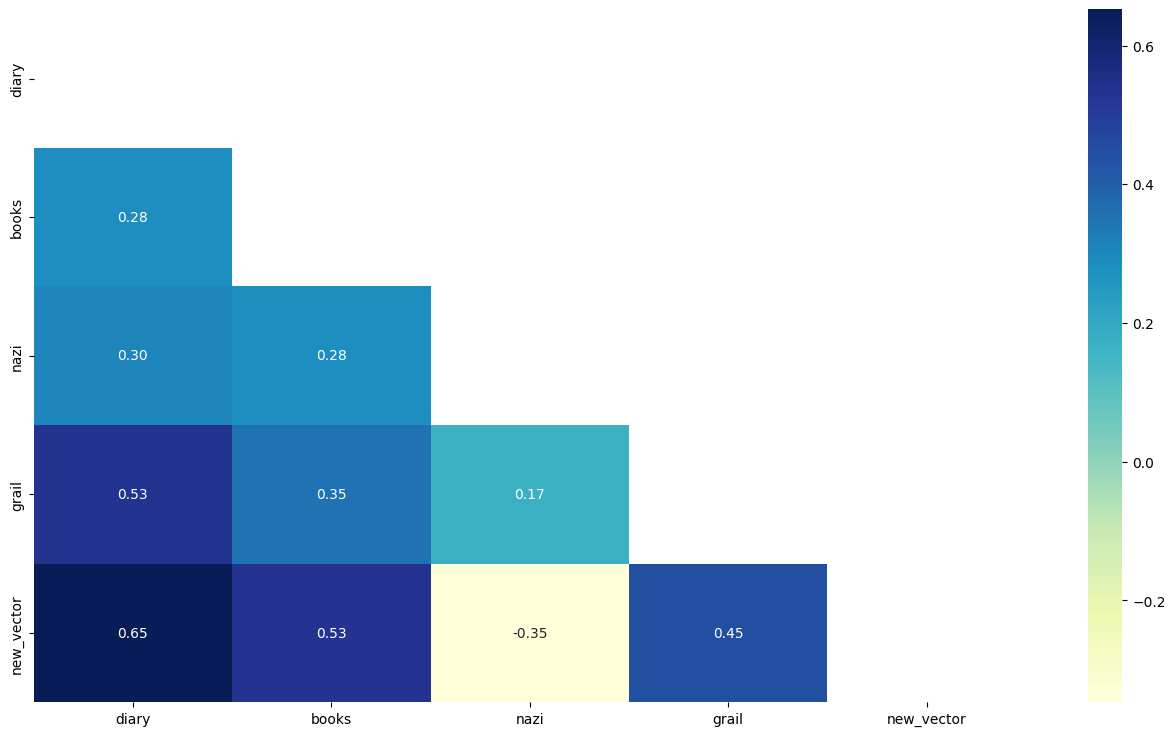

In [297]:
words = ["diary","books","nazi"]
vector1 = w2v_model.wv.get_vector(words[0])
vector2 = w2v_model.wv.get_vector(words[1])
vector3 = w2v_model.wv.get_vector(words[2])

new_vector = vector1 + vector2 - vector3

display(w2v_model.wv.most_similar(new_vector)[2:])
display(cosine_similarity([new_vector], [w2v_model.wv.get_vector("grail")])[0][0])
words.append("grail")
embeddings_matrix_distance(w2v_model, words, new_vector, "new_vector")

Salvar el diario de la quema de libros lleva al grial. La correlación no es fuerte pero si es la palabra más próxima al nuevo vector.